# Capstone Project
## Image classifier for the SVHN dataset
### Instructions

In this notebook, I will create a MLP model AND a CNN neural network that classify real-world images digits.


In [1]:
import tensorflow as tf
from scipy.io import loadmat
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D,BatchNormalization,Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np
import matplotlib.pyplot as plt

![SVHN overview image](data/svhn_examples.jpg)
For the capstone project, you will use the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This is an  image dataset of over 600,000 digit images in all, and is a harder dataset than MNIST as the numbers appear in the context of natural scene images. SVHN is obtained from house numbers in Google Street View images. 

* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.



In [3]:
# load the dataset

train = loadmat('data/train_32x32.mat')
test = loadmat('data/test_32x32.mat')

##  Inspect and preprocess the dataset
* Extract the training and testing images and labels separately from the train and test dictionaries .
* Select a random sample of images and corresponding labels from the dataset and display them in a figure.
* Convert the training and test images to grayscale by taking the average across all colour channels for each pixel.
* Select a random sample of the grayscale images and corresponding labels from the dataset, and display them in a figure.


In [4]:
X_train, y_train = train["X"], train["y"]
print(X_train.shape)
print(y_train.shape)

(32, 32, 3, 73257)
(73257, 1)


In [5]:
X_test, y_test = test["X"], test["y"]
print(X_test.shape)
print(y_test.shape)

(32, 32, 3, 26032)
(26032, 1)


In [6]:
# display labels 
np.unique(y_train)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=uint8)

In [7]:
# label correction, 0 instead of 10 
y_train = np.where(y_train==10,0,y_train)
y_test =  np.where(y_test==10,0,y_test)
np.unique(y_train)


array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

### Transposing the the train and test data by converting it from  
### (width, height, channels, size) -> (size, width, height, channels)

In [9]:
X_train = X_train.transpose((3,0,1,2))
X_test = X_test.transpose((3,0,1,2))
print(X_train.shape)
print(X_test.shape)

(73257, 32, 32, 3)
(26032, 32, 32, 3)


In [11]:
# I define a function to plot the images 

def plot_images(X,y,*,num =10,model = None):
    num_images = X.shape[0]

    random_inx = np.random.choice(num_images, num)
    random_images = X[random_inx, ...]
    random_labels = y[random_inx, ...]

    if model is None:
        fig, axes = plt.subplots(1,num, figsize=(15, 15))
        fig.subplots_adjust(wspace= 0.1)

        for i, ( image, label) in enumerate(zip(random_images, random_labels)):
            axes[i].imshow(np.squeeze(image),cmap=plt.get_cmap('gray'))
            axes[i].get_xaxis().set_visible(False)
            axes[i].get_yaxis().set_visible(False)
            axes[i].text(10., -1.5, f'Digit {label}')
    else:    
        predictions = model.predict(random_images)
        
        fig, axes = plt.subplots(num, 2, figsize=(16, 12))
        fig.subplots_adjust(hspace=0.4, wspace=-0.2)

        for i, (prediction, image, label) in enumerate(zip(predictions,
                                                           random_images,
                                                           random_labels)):
            axes[i, 0].imshow(np.squeeze(image))
            axes[i, 0].get_xaxis().set_visible(False)
            axes[i, 0].get_yaxis().set_visible(False)
            axes[i, 0].text(10., -1.5, f'Digit {label}')
            axes[i, 1].bar(np.arange(len(prediction)), prediction)
            axes[i, 1].set_xticks(np.arange(len(prediction)))
            axes[i, 1].set_title(f" Model prediction: {np.argmax(prediction)}")

        
    
    plt.show()

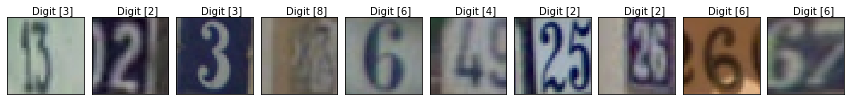

In [12]:
plot_images(X_train,y_train)

In [14]:
# rescale images as required
X_train_scaled = np.mean(X_train, axis=3, keepdims= True)
X_test_scaled = np.mean(X_test, axis=3, keepdims= True)

In [15]:
X_train_scaled.shape

(73257, 32, 32, 1)

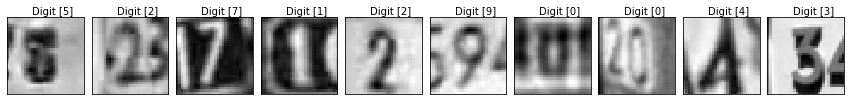

In [17]:
plot_images(X_train_scaled,y_train)

In [18]:
input_shape = (32,32,1)

## MLP neural network classifier
* Build an MLP classifier model using the Sequential API. Model should use only Flatten and Dense layers, with the final layer having a 10-way softmax output. 
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [37]:

def get_MLPmodel(input_shape):
 
    model = Sequential([
        Flatten(input_shape = input_shape),
        Dense(128,activation ="relu"),
        Dense(64,activation ="relu"),
        Dense(64,activation ="relu"),
        Dense(10,activation ="softmax")
    ])
    
    return model

In [38]:
MLPmodel = get_MLPmodel(input_shape)

In [39]:
MLPmodel.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               131200    
_________________________________________________________________
dense_13 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_14 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_15 (Dense)             (None, 10)                650       
Total params: 144,266
Trainable params: 144,266
Non-trainable params: 0
_________________________________________________________________


In [101]:
MLPmodel.compile(optimizer="adam",
             loss="sparse_categorical_crossentropy",
             metrics=["sparse_categorical_accuracy"])


In [102]:
model_checkpoint = ModelCheckpoint(
                    save_best_only=True,
                    save_weights_only=True,
                    monitor="val_sparse_categorical_accuracy",
                    filepath="checkpoints_best_MLP/MLPcheckpoint")
early_stopping = EarlyStopping(
                    monitor="val_sparse_categorical_accuracy",
                    patience=5,
                    mode="auto")

In [103]:
MLP_history = MLPmodel.fit(X_train_scaled,y_train,epochs = 30,
                        validation_split = 0.2,
                        callbacks =[model_checkpoint,early_stopping])

Train on 58605 samples, validate on 14652 samples
Epoch 1/30
58605/58605 [==============================] - 41s 693us/sample - loss: 3.9588 - sparse_categorical_accuracy: 0.1609 - val_loss: 2.0123 - val_sparse_categorical_accuracy: 0.3114
Epoch 2/30
58605/58605 [==============================] - 36s 616us/sample - loss: 1.7285 - sparse_categorical_accuracy: 0.4212 - val_loss: 1.5205 - val_sparse_categorical_accuracy: 0.5029
Epoch 3/30
58605/58605 [==============================] - 35s 606us/sample - loss: 1.4687 - sparse_categorical_accuracy: 0.5292 - val_loss: 1.4433 - val_sparse_categorical_accuracy: 0.5246
Epoch 4/30
58605/58605 [==============================] - 33s 566us/sample - loss: 1.3899 - sparse_categorical_accuracy: 0.5569 - val_loss: 1.2419 - val_sparse_categorical_accuracy: 0.6044
Epoch 5/30
58605/58605 [==============================] - 33s 563us/sample - loss: 1.3317 - sparse_categorical_accuracy: 0.5758 - val_loss: 1.4165 - val_sparse_categorical_accuracy: 0.5498
Epoch

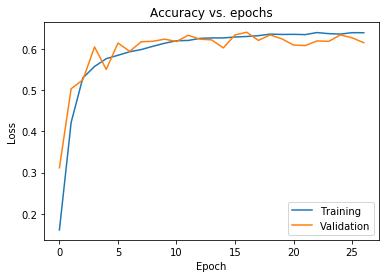

In [104]:

plt.plot(MLP_history.history['sparse_categorical_accuracy'])
plt.plot(MLP_history.history['val_sparse_categorical_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show() 

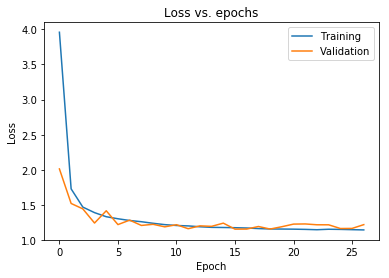

In [105]:
plt.plot(MLP_history.history['loss'])
plt.plot(MLP_history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show() 

In [106]:
# Evaluate the model on the test set

test_loss, test_acc = MLPmodel.evaluate(X_test_scaled, y_test, verbose=0)
print("Test loss: {:.3f}\nTest accuracy: {:.2f}%".format(test_loss, 100 * test_acc))

Test loss: 1.306
Test accuracy: 59.76%


## CNN neural network classifier
* Build a CNN classifier model using the Sequential API. Model use the Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense and Dropout layers. The final layer again have a 10-way softmax output. 
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [19]:
def get_CNNmodel(input_shape):
 
    model = Sequential([
        Conv2D(32, (3, 3), padding='same', 
                            activation='relu',
                            input_shape=input_shape),
        BatchNormalization(),
        Conv2D(32, (3, 3), padding='same', 
                            activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.3),
        Conv2D(64, (3, 3), padding='same', 
                            activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.3),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.4),    
        Dense(10,  activation='softmax')
    ])
 
    return model


In [20]:
CNNmodel = get_CNNmodel(input_shape)

In [21]:
CNNmodel.compile(optimizer="adam",
             loss="sparse_categorical_crossentropy",
             metrics=["sparse_categorical_accuracy"])

In [22]:
model_checkpoint = ModelCheckpoint(
                    save_best_only=True,
                    save_weights_only=True,
                    monitor="val_sparse_categorical_accuracy",
                    filepath="checkpoints_best_CNN/CNNcheckpoint")
early_stopping = EarlyStopping(
                    monitor="val_sparse_categorical_accuracy",
                    patience=5,
                    mode="auto")


In [23]:
CNN_history = CNNmodel.fit(X_train_scaled,y_train,epochs = 20,
            validation_split = 0.2,
            callbacks =[model_checkpoint,early_stopping])

Train on 58605 samples, validate on 14652 samples
Epoch 1/20
58605/58605 [==============================] - 1001s 17ms/sample - loss: 1.0220 - sparse_categorical_accuracy: 0.6697 - val_loss: 0.5046 - val_sparse_categorical_accuracy: 0.8527
Epoch 2/20
58605/58605 [==============================] - 981s 17ms/sample - loss: 0.6236 - sparse_categorical_accuracy: 0.8102 - val_loss: 0.4637 - val_sparse_categorical_accuracy: 0.8778
Epoch 3/20
58605/58605 [==============================] - 984s 17ms/sample - loss: 0.5400 - sparse_categorical_accuracy: 0.8347 - val_loss: 0.3887 - val_sparse_categorical_accuracy: 0.8885
Epoch 4/20
58605/58605 [==============================] - 1008s 17ms/sample - loss: 0.5039 - sparse_categorical_accuracy: 0.8467 - val_loss: 0.3662 - val_sparse_categorical_accuracy: 0.8952
Epoch 5/20
58605/58605 [==============================] - 987s 17ms/sample - loss: 0.4701 - sparse_categorical_accuracy: 0.8583 - val_loss: 0.3745 - val_sparse_categorical_accuracy: 0.8971
Epo

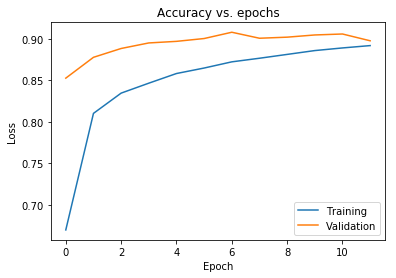

In [24]:

plt.plot(CNN_history.history['sparse_categorical_accuracy'])
plt.plot(CNN_history.history['val_sparse_categorical_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show() 

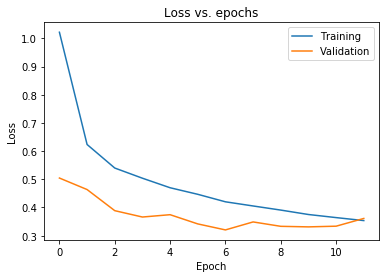

In [25]:

plt.plot(CNN_history.history['loss'])
plt.plot(CNN_history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show() 

In [50]:
# Evaluate the model on the test set

test_loss, test_acc = CNNmodel.evaluate(X_test_scaled, y_test, verbose=0)
print("Test loss: {:.3f}\nTest accuracy: {:.2f}%".format(test_loss, 100 * test_acc))


Test loss: 0.393
Test accuracy: 88.98%


## Get model predictions
* Randomly select 5 images and corresponding labels from the test set and display the images with their labels.
* Alongside the image and label, show each model’s predictive distribution as a bar chart, and the final model prediction given by the label with maximum probability.

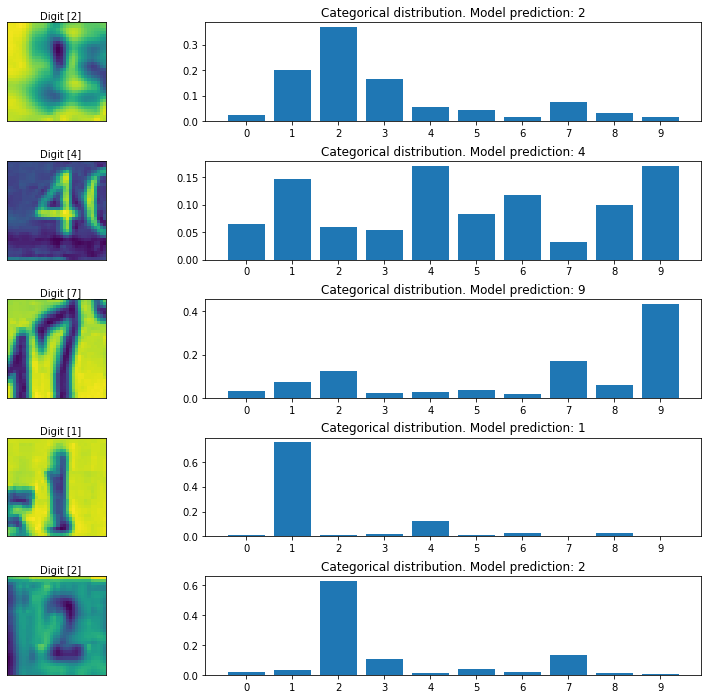

In [46]:
plot_images(X_test_scaled,y_test,num = 5, model = MLPmodel)

#### we can see the MLP Model´s performance is poor,  it predicted the digit 7 to be digit 9 and it could not predict for sure whether the second image represent the 4 or digit 9 or maybe other digit ( probability < 0.20 ) . Now let´s see how well the CNN model performs. 

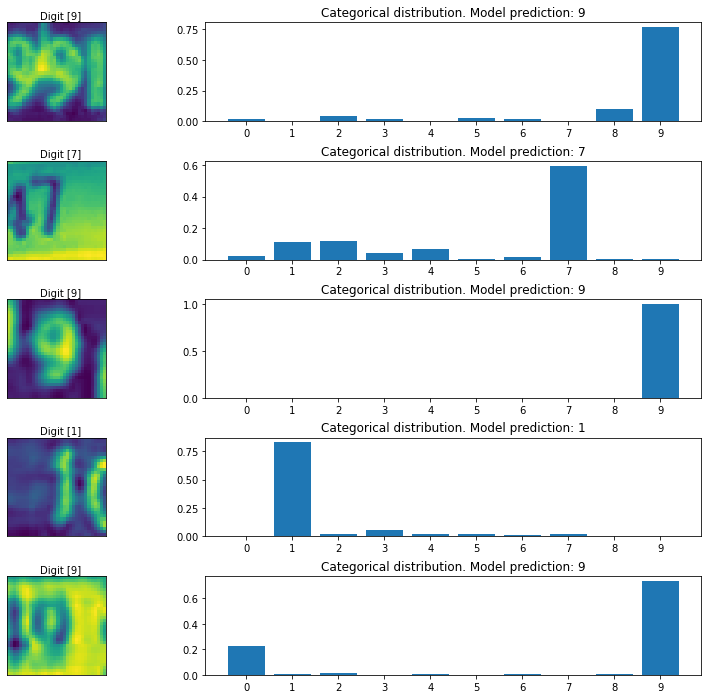

In [49]:
plot_images(X_test_scaled,y_test,num = 5, model = CNNmodel)

### much better than MLP Model